In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from scipy import stats
import os

In [2]:
def plot_violin(list1, list2, list3, list4, labels=('List 1', 'List 2', 'List 3', 'List4')):
    # Convert inputs to arrays and concatenate
    values = np.concatenate([np.asarray(list1), np.asarray(list2), 
                             np.asarray(list3), np.asarray(list4)])
    
    # Create categories based on lengths of original inputs
    categories = (
        [labels[0]] * len(list1) +
        [labels[1]] * len(list2) +
        [labels[2]] * len(list3) + 
        [labels[3]] * len(list4) 
    )
    
    df = pd.DataFrame({'Values': values, 'Category': categories})
    custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='Category', y='Values', data=df, palette=custom_palette)
    plt.ylim(bottom=0)
    plt.ylabel("Energy (J)")
    plt.xlabel("Text Editor")
    plt.title("Violin Plots of the Energy Consumption of the Text Editors")
    plt.show()


In [3]:
def plot_scatter_energy_per_run(energy, color='green', editor='none', marker_size=50):
    plt.figure(figsize=(12, 6))
    x = list(range(len(energy)))
    plt.scatter(x, energy, 
                label='Energy consumption (J)', 
                color=color, 
                alpha=0.7,
                s=marker_size,
                edgecolor='black')
    plt.xlabel('Run Number')
    plt.ylabel('Total Energy Consumption (J)')
    plt.title(f'Energy Consumption per Run - {editor}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def shapiroWilk(energy):
    stat, p = stats.shapiro(energy)
    alpha = 0.05
    return (p > alpha), p

def welch(energy1, energy2, energy3, energy4, labels=('List 1', 'List 2', 'List 3', 'List4')):
    pairs = [(energy1, energy2), (energy1, energy3), (energy1, energy4), (energy2, energy3), (energy2, energy4), (energy3, energy4)]
    labels = [
        f"{labels[0]} vs {labels[1]}", f"{labels[0]} vs {labels[2]}", f"{labels[0]} vs {labels[3]}",
        f"{labels[1]} vs {labels[2]}", f"{labels[1]} vs {labels[3]}", f"{labels[2]} vs {labels[3]}"
    ]

    for (d1, d2), label in zip(pairs, labels):
        t_stat, p_val = stats.ttest_ind(d1, d2)
        print(f"{label}: t = {t_stat:.4f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print("  → Significant difference ✅")
        else:
            print("  → No significant difference ❌")

def mann_whitney(energy1, energy2, energy3, energy4, labels=('List 1', 'List 2', 'List 3', 'List4')):
    pairs = [(energy1, energy2), (energy1, energy3), (energy1, energy4), 
             (energy2, energy3), (energy2, energy4), (energy3, energy4)]
    labels = [
        f"{labels[0]} vs {labels[1]}", f"{labels[0]} vs {labels[2]}", 
        f"{labels[0]} vs {labels[3]}", f"{labels[1]} vs {labels[2]}", 
        f"{labels[1]} vs {labels[3]}", f"{labels[2]} vs {labels[3]}"
    ]

    for (d1, d2), label in zip(pairs, labels):
        u_stat, p_val = stats.mannwhitneyu(d1, d2)
        print(f"{label}: U = {u_stat:.3f}, p = {p_val:.3f}")
        if p_val < 0.05:
            print("  → Significant difference ✅")
        else:
            print("  → No significant difference ❌")

In [13]:
def calculate_mean_and_std_dev(data):
    data = np.array(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

# Analysis

## 1. Load Files

In [ ]:
def load_and_filter_runs(text_editor, num_runs=30):
    runs_list = []
    included_runs = 0 
    for i in range(0, num_runs):
        file_name = f'results-{text_editor}-{i}.csv'
        df = pd.read_csv(file_name)
        print(f"File loaded: results-{text_editor}-{i}.csv")
        total_energy = df['CPU_ENERGY (J)'].iloc[-1] - df['CPU_ENERGY (J)'].iloc[0]
        runs_list.append(total_energy)
        included_runs += 1
    return runs_list, included_runs


note, note_runs = load_and_filter_runs('note', num_runs=30)
plus, plus_runs = load_and_filter_runs('plus', num_runs=30)
word, word_runs = load_and_filter_runs('word', num_runs=30)
vs, vs_runs = load_and_filter_runs('vs', num_runs=30)
print(f"VS valid runs: {vs_runs}")
print(f"Note valid runs: {note_runs}")
print(f"Word valid runs: {word_runs}")
print(f"Plus valid runs: {plus_runs}")

File loaded: results-note-0.csv
File loaded: results-note-1.csv
File loaded: results-note-2.csv
File loaded: results-note-3.csv
File loaded: results-note-4.csv
File loaded: results-note-5.csv
File loaded: results-note-6.csv
File loaded: results-note-7.csv
File loaded: results-note-8.csv
File loaded: results-note-9.csv
File loaded: results-note-10.csv
File loaded: results-note-11.csv
File loaded: results-note-12.csv
File loaded: results-note-13.csv
File loaded: results-note-14.csv
File loaded: results-note-15.csv
File loaded: results-note-16.csv
File loaded: results-note-17.csv
File loaded: results-note-18.csv
File loaded: results-note-19.csv
File loaded: results-note-20.csv
File loaded: results-note-21.csv
File loaded: results-note-22.csv
File loaded: results-note-23.csv
File loaded: results-note-24.csv
File loaded: results-note-25.csv
File loaded: results-note-26.csv
File loaded: results-note-27.csv
File loaded: results-note-28.csv
File loaded: results-note-29.csv
File loaded: results

In [6]:
def filter_based_on_z_score(data, threshold=3):
    """
    Filters data based on Z-scores. Values with Z-scores greater than the threshold
    (in absolute value) will be excluded.
    
    Parameters:
    - data (array-like): The input data to filter.
    - threshold (float): The Z-score threshold for filtering. Default is 2.
    
    Returns:
    - filtered_data (numpy array): The filtered data based on Z-score threshold.
    """
    # Convert input data to a numpy array if it's not already
    data = np.array(data)

    # Calculate the mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)

    # Calculate Z-scores
    z_scores = (data - mean) / std_dev

    # Filter data based on the absolute Z-score threshold
    filtered_data = data[np.abs(z_scores) < threshold]

    return filtered_data

In [ ]:
note = filter_based_on_z_score(note)
print(f"Number of NotePad runs after outlier rejection: {len(note)}")
word = filter_based_on_z_score(word)
print(f"Number of MS word runs after outlier rejection: {len(word)}")
plus = filter_based_on_z_score(plus)
print(f"Number of Notepad++ runs after outlier rejection: {len(plus)}")
vs = filter_based_on_z_score(vs)
print(f"Number of Visual Studio Code runs after outlier rejection: {len(vs)}")




Number of NotePad runs after outlier rejection: 30
Number of MS word runs after outlier rejection: 30
Number of Notepad++ runs after outlier rejection: 30
Number of Visual Studio Code runs after outlier rejection: 29


In [18]:
note_mean, note_std_dev = calculate_mean_and_std_dev(note)
plus_mean, plus_std_dev = calculate_mean_and_std_dev(plus)
word_mean, word_std_dev = calculate_mean_and_std_dev(word)
vs_mean, vs_std_dev = calculate_mean_and_std_dev(vs)

print(f"Mean of Total Energy consumption of NotePad: {note_mean:.2f}, Standard Deviation {note_std_dev:.2f}")
print(f"Mean of Total Energy consumption of NotePad++: {plus_mean:.2f}, Standard Deviation {plus_std_dev:.2f}")
print(f"Mean of Total Energy consumption of MS Word: {word_mean:.2f}, Standard Deviation {word_std_dev:.2f}")
print(f"Mean of Total Energy consumption of Visual Studio Code: {vs_mean:.2f}, Standard Deviation {vs_std_dev:.2f}")

plus_to_note = ((note_mean - plus_mean) / plus_mean) * 100
note_to_word = ((word_mean - note_mean) / note_mean) * 100
word_to_vs = ((vs_mean - word_mean) / word_mean) * 100
plus_to_vs = ((vs_mean - plus_mean) / plus_mean) * 100

print(f"Percentage Change from Notepad++ to Notepad: {plus_to_note:.2f}%")
print(f"Percentage Change from Notepad to MS Word: {note_to_word:.2f}%")
print(f"Percentage Change from MS Word to VS Code: {word_to_vs:.2f}%")
print(f"Percentage Change from Notepad++ to VS Code: {plus_to_vs:.2f}%")


Mean of Total Energy consumption of NotePad: 188.87, Standard Deviation 11.32
Mean of Total Energy consumption of NotePad++: 178.33, Standard Deviation 9.67
Mean of Total Energy consumption of MS Word: 233.62, Standard Deviation 19.07
Mean of Total Energy consumption of Visual Studio Code: 255.07, Standard Deviation 15.52
Percentage Change from Notepad++ to Notepad: 5.91%
Percentage Change from Notepad to MS Word: 23.69%
Percentage Change from MS Word to VS Code: 9.18%
Percentage Change from Notepad++ to VS Code: 43.03%


### 1.1  Test of Normality

Done using Shapiro Wilks test

In [8]:
is_normal, p = shapiroWilk(note)
print(f"Is NotePad data normal?: {is_normal}, p-value {p}")
is_normal, p = shapiroWilk(word)
print(f"Is Word data normal?: {is_normal}, p-value {p}")
is_normal, p = shapiroWilk(plus)
print(f"Is ++ data normal?: {is_normal}, p-value {p}")
is_normal, p = shapiroWilk(vs)
print(f"Is VS data normal?: {is_normal}, p-value {p}")

Is NotePad data normal?: False, p-value 0.0008683737022737976
Is Word data normal?: False, p-value 0.011037480977150084
Is ++ data normal?: False, p-value 0.00011004743352952411
Is VS data normal?: True, p-value 0.06695914756326109


### 1.2 Significance testing
- Done using Welch's T-test

In [21]:
#welch(note, plus, vs, word, labels=('NotePad', 'NotePad++', 'Visual Studio Code', 'MS Word'))
mann_whitney(note, plus, vs, word, labels=('NotePad', 'NotePad++', 'Visual Studio Code', 'MS Word'))

NotePad vs NotePad++: U = 731.0000, p = 0.0000
  → Significant difference ✅
NotePad vs Visual Studio Code: U = 0.0000, p = 0.0000
  → Significant difference ✅
NotePad vs MS Word: U = 7.0000, p = 0.0000
  → Significant difference ✅
NotePad++ vs Visual Studio Code: U = 0.0000, p = 0.0000
  → Significant difference ✅
NotePad++ vs MS Word: U = 0.0000, p = 0.0000
  → Significant difference ✅
Visual Studio Code vs MS Word: U = 684.0000, p = 0.0002
  → Significant difference ✅


## 2. Graphs

/var/folders/cw/g2d6pb556jzc3j2xglmbb0gw0000gn/T/ipykernel_23405/1641261661.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Values', data=df, palette=custom_palette)


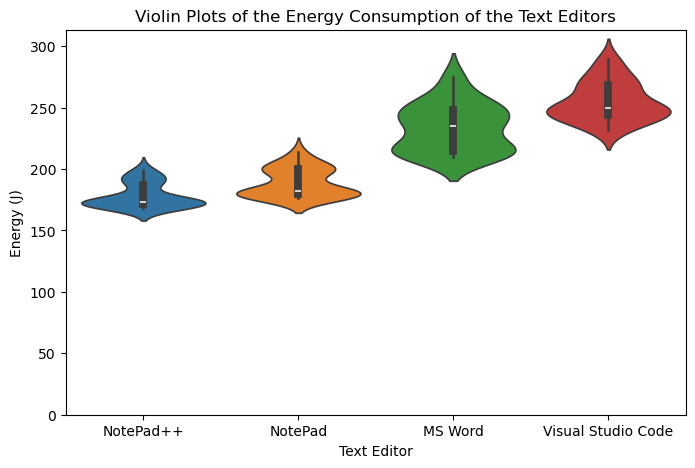

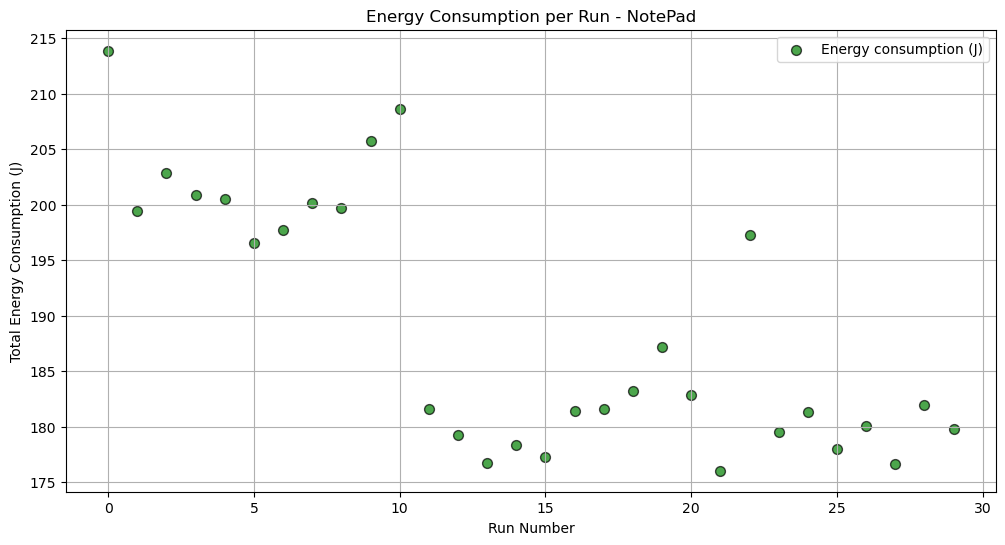

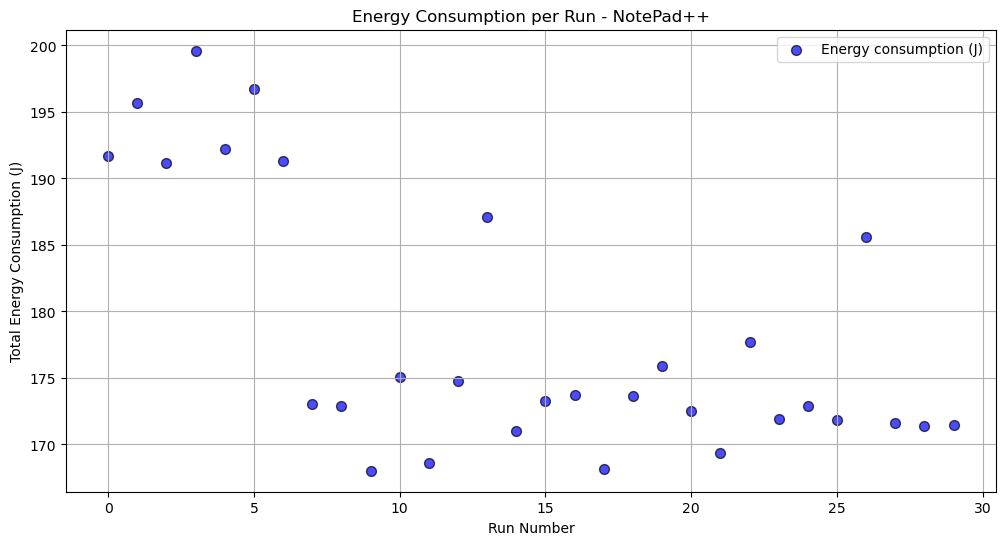

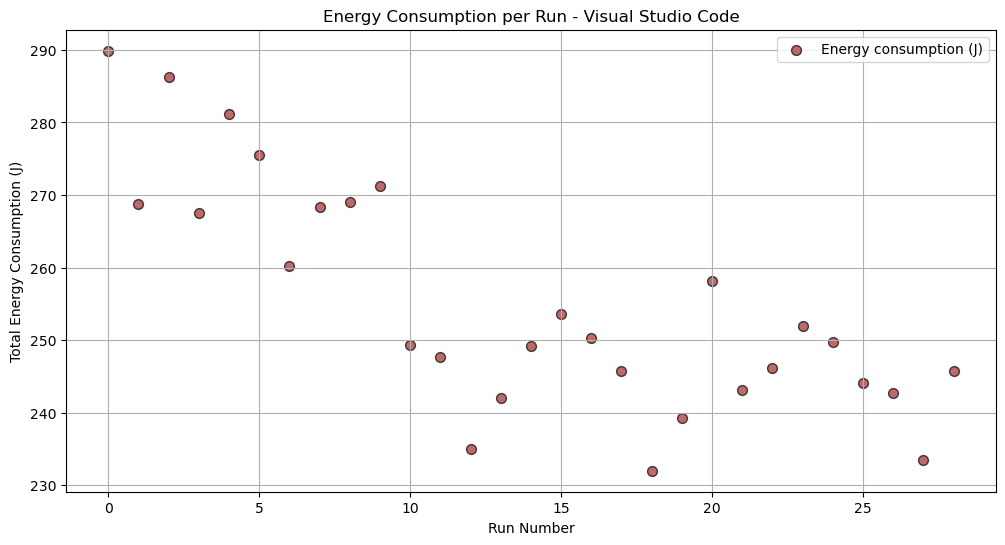

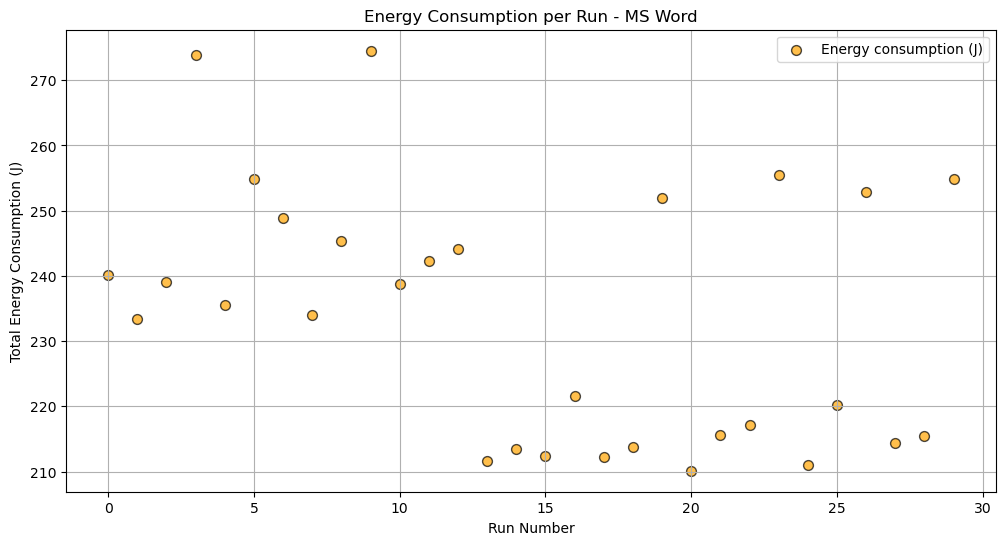

In [10]:
plot_violin(plus,note,word,vs,labels=('NotePad++', 'NotePad', 'MS Word', 'Visual Studio Code'))
plot_scatter_energy_per_run(note,editor='NotePad')
plot_scatter_energy_per_run(plus, color='blue',editor='NotePad++')
plot_scatter_energy_per_run(vs, color='brown', editor='Visual Studio Code')
plot_scatter_energy_per_run(word, color='orange', editor='MS Word')